# ESP Trip Cause Classification using NLP
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Anomaly Detection and Reliability

**Objective:** Automatically categorize unstructured operator logs into standardized ESP failure reasons.
**Techniques:** Natural Language Processing (NLP), TF-IDF Vectorization, Support Vector Machines (SVM).

In the Oil & Gas industry, "Trip Logs" are often manually entered by operators. A comment like *"UL trip, restarting"* needs to be classified as **"Underload"** to perform proper reliability analysis. We will build a model to do this.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP Libraries
import nltk
from nltk.corpus import stopwords
import spacy

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download NLTK stopwords
nltk.download('stopwords')

# Load Spacy English model (ensure you ran: python -m spacy download en_core_web_sm)
nlp = spacy.load("en_core_web_sm")

print("Libraries imported successfully.")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Libraries imported successfully.


## 1. Data Loading and Exploration
We load the dataset containing the raw text (`Operator_Comment`) and the ground truth labels (`Standard_Category`).

In [2]:
# Load the dataset
df = pd.read_csv('esp_trip_logs.csv')

# View first few rows
print(f"Total records: {df.shape[0]}")
df.head()

Total records: 25


,Date,Well_ID,Operator_Comment,Standard_Category
0,2023-01-01,W-101,ESP tripped on underload setting,Underload
1,2023-01-02,W-102,high vibration detected on pump intake,Mechanical
2,2023-01-05,W-103,motor temp high shut down,Overheating
3,2023-01-10,W-101,ul trip reset and restart,Underload
4,2023-01-12,W-105,variable speed drive fault code 303,Electrical


## 2. Exploratory Data Analysis (EDA)
Let's look at the distribution of trip categories to see if our dataset is balanced.

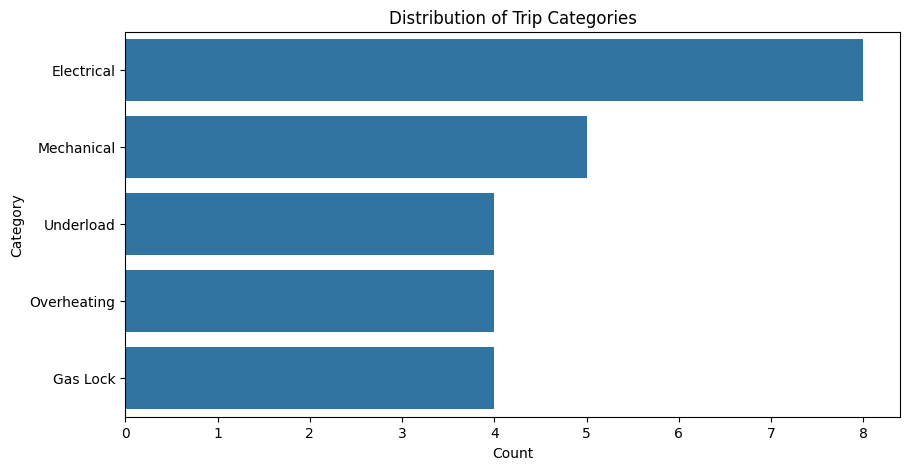

In [3]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Standard_Category', data=df, order=df['Standard_Category'].value_counts().index)
plt.title('Distribution of Trip Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

## 3. Text Preprocessing
Raw text contains noise (punctuation, mixed casing, stopwords like "the", "on"). We need to clean it.

**Steps:**
1.  **Lowercase:** Convert all text to lowercase.
2.  **Remove Punctuation:** Strip symbols.
3.  **Lemmatization (SpaCy):** Convert words to their base form (e.g., "tripped" -> "trip", "fuses" -> "fuse").

In [4]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Process with SpaCy for Lemmatization
    doc = nlp(text)
    
    # 3. Filter stopwords and punctuation, keep only alpha characters
    # We keep the lemma (base form) of the word
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    
    return " ".join(tokens)

# Apply to dataframe
df['Cleaned_Comment'] = df['Operator_Comment'].apply(preprocess_text)

# Show comparison
df[['Operator_Comment', 'Cleaned_Comment']].head()

,Operator_Comment,Cleaned_Comment
0,ESP tripped on underload setting,esp trip underload set
1,high vibration detected on pump intake,high vibration detect pump intake
2,motor temp high shut down,motor temp high shut
3,ul trip reset and restart,ul trip reset restart
4,variable speed drive fault code 303,variable speed drive fault code


## 4. Train-Test Split
We split the data to train the model on one set and validate it on unseen data.

In [5]:
X = df['Cleaned_Comment']
y = df['Standard_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 17
Testing samples: 8


## 5. Pipeline Construction (TF-IDF + Classifier)
We will use a `Pipeline` to combine the vectorization and classification steps.

1.  **TF-IDF Vectorizer:** Converts text into a matrix of numbers. It gives weight to words that are specific to a document (like "underload" or "vibration") and lowers the weight of common words.
2.  **Linear SVC:** Support Vector Classifier is generally excellent for text classification tasks due to its ability to handle high-dimensional sparse data.

In [6]:
# Create a pipeline
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorization
    ('clf', LinearSVC(random_state=42))  # Classifier
])

# Train the model
text_clf.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


## 6. Model Evaluation
We check the accuracy and the confusion matrix to see where the model might be getting confused.

Accuracy: 1.00

Classification Report:

              precision    recall  f1-score   support

  Electrical       1.00      1.00      1.00         2
    Gas Lock       1.00      1.00      1.00         3
  Mechanical       1.00      1.00      1.00         2
   Underload       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



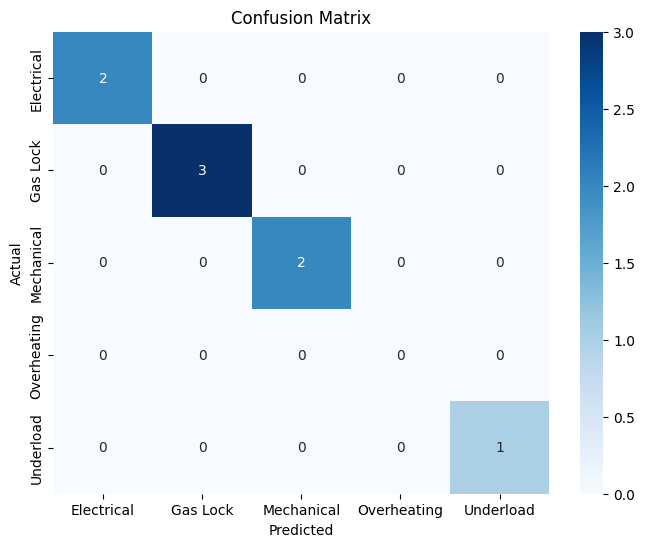

In [7]:
# Predict on test data
y_pred = text_clf.predict(X_test)

# Print Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred, labels=text_clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=text_clf.classes_, yticklabels=text_clf.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 7. Inference (Testing New Data)
Let's simulate new field operator entries to see how the model categorizes them.

In [8]:
new_comments = [
    "pump shut down due to high vibes",
    "UL detected waiting for fluid level",
    "cable burned out",
    "gas locking suspected flowline choked"
]

# Preprocess new data
clean_new_comments = [preprocess_text(c) for c in new_comments]

# Predict
predictions = text_clf.predict(clean_new_comments)

for comment, category in zip(new_comments, predictions):
    print(f"Log: '{comment}'  ->  Category: **{category}**")

Log: 'pump shut down due to high vibes'  ->  Category: **Mechanical**
Log: 'UL detected waiting for fluid level'  ->  Category: **Underload**
Log: 'cable burned out'  ->  Category: **Electrical**
Log: 'gas locking suspected flowline choked'  ->  Category: **Gas Lock**
